In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import fastai
from fastai import *
from fastai.vision import *
from upassai import *
fastai.__version__

'1.0.28'

## Prepare data

In [4]:
vggface2_light_url = '../data/vggface2/vggface2-light'

In [7]:
faces_valid_df = compile_faces_dataset(vggface2_light_url, qty=-1)
faces_valid_df.describe()

,source,target,similarity
count,700,700,700
unique,350,382,2
top,valid/n002414/0151_01.jpg,valid/n007166/0167_01.jpg,1
freq,2,10,350


In [8]:
faces_train_df = compile_faces_dataset(
    vggface2_light_url, folder='train', qty=-1)
faces_train_df.describe()

,source,target,similarity
count,1200,1200,1200
unique,600,628,2
top,train/n001061/0175_01.jpg,train/n007396/0116_01.jpg,1
freq,2,12,600


In [9]:
faces_df = pd.concat([faces_valid_df, faces_train_df])
faces_df.describe()

,source,target,similarity
count,1900,1900,1900
unique,950,1010,2
top,train/n001061/0175_01.jpg,train/n007396/0116_01.jpg,1
freq,2,12,950


In [10]:
source_bunch = create_bunch(faces_df, cols='source', path=vggface2_light_url)
target_bunch = create_bunch(faces_df, cols='target', path=vggface2_light_url)

In [11]:
train_ds = TwinDataset(source_bunch.train_ds, target_bunch.train_ds)
valid_ds = TwinDataset(source_bunch.valid_ds, target_bunch.valid_ds)

In [33]:
twin_databunch = DataBunch.create(
    train_ds=train_ds, valid_ds=valid_ds, path=vggface2_light_url, bs=16)

## Train

In [37]:
learner = Learner(twin_databunch, SiameseNetwork(), loss_func=contrastive_loss, path='./models')
print(learner)

Learner(data=DataBunch;
Train: <upassai.data.TwinDataset object at 0x7f38d8fc7a90>;
Valid: <upassai.data.TwinDataset object at 0x7f38d8fc75f8>;
Test: None, model=SiameseNetwork(
  (cnn1): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3):

In [38]:
# freeze resnet
learner.freeze_to(126)

In [39]:
learner.fit_one_cycle(50)

Total time: 02:09
epoch  train_loss  valid_loss
1      1.537984    1.564268    (00:13)
2      1.241733    1.394132    (00:12)
3      0.971207    1.264445    (00:12)
4      0.811461    1.188132    (00:12)
5      0.674430    1.190966    (00:12)
6      0.550463    1.195011    (00:13)
7      0.476022    1.183436    (00:12)
8      0.389182    1.221080    (00:12)
9      0.326265    1.197677    (00:12)
10     0.297263    1.219659    (00:12)



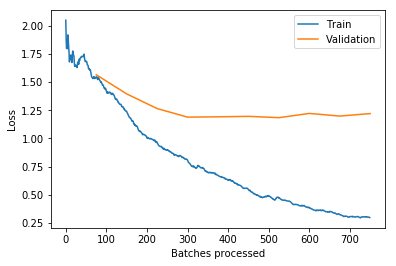

In [40]:
learner.recorder.plot_losses()

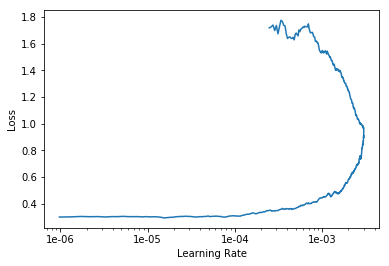

In [41]:
learner.recorder.plot()

In [ ]:
learner.save('resnet50-frozen-after20')